In [1]:
import numpy as np;
import tensorflow as tf;

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
y_train = y_train.astype("int32").flatten() # converting from shape (50000, 1) to (50000,)
y_test = y_test.astype("int32").flatten()

In [4]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size = 10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
class CIFAR10CNN:
    def __init__(self):
        # He initialization for weights: (sqrt(2/fan_in))
        # He initializer compensates by doubling the variance of the initial weights ((2/n) instead of (1/n))
        he_init = tf.keras.initializers.HeNormal()

        # Convolutional layer 1: 32 filters of 3*3*3 
        # (kernel size 3x3, input channels 3(rgb))
        self.conv1_filters = tf.Variable(
            he_init(shape=(3,3,3,32))
        )

        self.conv1_bias = tf.Variable(
            tf.zeros(shape=(32,))
        )

        # conv Layer 2: 32 filter of 3x3x32
        # 32 feature maps from previous layer
        self.conv2_filters = tf.Variable(
            he_init(shape=(3,3,32,64))
        )
        self.conv2_bias = tf.Variable(
            tf.zeros((64,))
        )

        # convlayer 3: 64 layers of 3x3x64
        self.conv3_filters = tf.Variable(
            he_init(shape=(3,3,64,64))
        )

        self.conv3_bias = tf.Variable(
            tf.zeros((64,))
        )

        # Dense layer 1: 
        # After two max pools the image size goes 32->16-->8
        # 32x32x3 -> 16x16x32 -> 8x8x64, where 32 and 64 are the feature maps(output channels) from the convolution
        #Convolution changes depth (channels), pooling changes height & width.

        self.dense1_weights = tf.Variable(
            he_init(shape = (8*8*64, 128)) 
        )

        self.dense1_bias = tf.Variable(
            tf.zeros((128,))
        )
        
        self.dense2_weights = tf.Variable(
            he_init(shape = (128, 64)) 
        )

        self.dense2_bias = tf.Variable(
            tf.zeros((64,))
        )

        # Dense layer 2: Output layer with 10 classes
        self.output_weights = tf.Variable(
            he_init(shape=(64, 10))
        )

        self.output_bias = tf.Variable(
            tf.zeros((10,))
        )

        # adding hte dropout for overfitting
        self.dropout_rate = 0.25


    def conv2d(self, x, filters, bias, stride=1, pad="SAME"):
        # x = (batch_size, height, width, in_channels)
        # filters = (filter_height, filter_width, in_channels, out_channels
        # One filter ONE feature map, so we add out_channels number of filters
        # bias = out_channels
        # stride [batch_stride, height, width, channels_stride]
        x = tf.nn.conv2d(x, filters, strides=[1,stride, stride,1], padding=pad)
        x = tf.nn.bias_add(x, bias)
        # X= convolution result + bias
        return x
    

    def max_pool2d(self, x, pool_size=2):
        # k_size 2 means take 2x2 window
        # stride = 2 means move 2 steps/ no overlap
        return tf.nn.max_pool2d(x, ksize=pool_size, strides=pool_size, padding="VALID")


    def forward_pass(self, x, training = True):
        # conv1->relu->pool1
        x = self.conv2d(x,self.conv1_filters, self.conv1_bias)
        x = tf.nn.relu(x)
        if training:
            x = tf.nn.dropout(x, rate=0.2)
        x = self.max_pool2d(x)

        # conv2->relu->max_pool2
        x = self.conv2d(x, self.conv2_filters, self.conv2_bias)
        x = tf.nn.relu(x)
        if training:
            x = tf.nn.dropout(x, rate=0.2)
        x = self.max_pool2d(x)

        # conv3->relu(no pooling)
        x = self.conv2d(x, self.conv3_filters, self.conv3_bias)
        x = tf.nn.relu(x)
        if training:
            x = tf.nn.dropout(x, rate=0.2)

        x = tf.reshape(x,(x.shape[0], -1)) #x.shape[0] = batch_size, -1 =  figure out yourself(it does 8*8864)))


        # Dense layer 1 (Dense1->relu)
        x = tf.matmul(x, self.dense1_weights) + self.dense1_bias
        x = tf.nn.relu(x)
        # Dropout in dense layer
        if training:
            x = tf.nn.dropout(x, self.dropout_rate)

        # Dense layer 2 (Dense2->relu)
        x = tf.matmul(x, self.dense2_weights) + self.dense2_bias
        x = tf.nn.relu(x) 
        # Dropout in dense layer
        if training:
            x = tf.nn.dropout(x, self.dropout_rate)

        # Dense2(output layer)
        logits = tf.matmul(x, self.output_weights) + self.output_bias
        return logits

In [15]:
def training_step(model, optimizer, images, labels):
    with tf.GradientTape() as tape:
        # Forward Pass
        logits = model.forward_pass(images, training = True)

        # Loss calculation
        # sparse categorical cross-entropy
        # reduce_mean takes the average of the individual loss value
        batch_loss = tf.reduce_mean(
            # we are using sparse because labels are integers not one hot
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = labels,
                logits = logits
            )
        )
        l2_lamda = 0.0003
        l2_loss = l2_lamda * sum(
            tf.reduce_sum(tf.square(w)) for w in [
                model.conv1_filters, model.conv2_filters,
                model.conv3_filters, model.dense1_weights,
                model.dense2_weights, model.output_weights
            ]
        )
        total_loss = batch_loss + l2_loss

    trainable_vars = [
        model.conv1_filters, model.conv1_bias,
        model.conv2_filters, model.conv2_bias, 
        model.conv3_filters, model.conv3_bias,


        model.dense1_weights, model.dense1_bias,
        model.dense2_weights, model.dense2_bias,
        model.output_weights, model.output_bias
    ]

    # this handles the backpropagation, using chain-rule
    gradients = tape.gradient(total_loss, trainable_vars)
    # apply_gradients does gradient descent(adam optimizer)
    #zip() creates the exact pairing: (gradients[0], trainable_vars[0]), (gradients[1], trainable_vars[1]), etc.
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return total_loss, logits

def compute_accuracy(model, dataset):
    correct = 0
    total = 0
    for batch_images, batch_labels in dataset:
        # logits has raw score for eac hclass ([batch_size, 10])
        logits = model.forward_pass(batch_images, training = False)
        # find the maximum value(axis=1 is classes, if axis = 0 then it would be batch)
        predictions = tf.argmax(logits, axis=1)
        predictions = tf.cast(predictions, tf.int32)

        # compares element wise for all in a batch
        # tf.float32 converts bollean to float
        correct += tf.reduce_sum(tf.cast(predictions == batch_labels, tf.float32))
        total += batch_labels.shape[0]
    return float(correct / total)

In [19]:
model = CIFAR10CNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

best_val_acc = 0.0
patience = 10          # stop if no improvement for 10 epochs
patience_counter = 0
best_model_weights = None

for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0

    # Training phase
    for batch_images, batch_labels in train_dataset:
        batch_loss, _ = training_step(model, optimizer, batch_images, batch_labels)
        epoch_loss += batch_loss
        batch_count += 1

    # Calculate accuracies
    val_accuracy = compute_accuracy(model, test_dataset)
    train_accuracy = compute_accuracy(model, train_dataset.take(100))

    avg_loss = epoch_loss / batch_count if batch_count > 0 else float('nan')
    print(
        f"Epoch {epoch+1}/{epochs} --> "
        f"| Train Loss: {avg_loss:.4f} "
        f"| Train Accuracy: {train_accuracy*100:.2f}% "
        f"| Val Accuracy: {val_accuracy*100:.2f}%"
    )
    print("." * 100)

    # ---- Early-stopping logic based on validation accuracy ----
    # Consider a tiny epsilon to avoid float-equality issues
    eps = 1e-8

    if val_accuracy > best_val_acc + eps:
        # Improvement: save best accuracy and model weights
        best_val_acc = val_accuracy
        patience_counter = 0

        # Collect model variables (all tf.Variable attributes on the model)
        model_vars = [v for v in vars(model).values() if isinstance(v, tf.Variable)]
        # Save copies of the values (numpy arrays) so we can restore later
        best_model_weights = [v.numpy() for v in model_vars]
    else:
        # No improvement this epoch
        patience_counter += 1

    # Stop if val accuracy reached (approx) 100%
    if best_val_acc >= 0.9999:
        print("Validation accuracy ≈ 100% reached. Stopping early.")
        break

    # Stop if no improvement for `patience` epochs
    if patience_counter >= patience:
        print(f"No validation improvement for {patience} epochs. Early stopping.")
        # restore best weights if available
        
        if best_model_weights is not None:
            current_model_vars = [v for v in vars(model).values() if isinstance(v, tf.Variable)]
            # Assign saved weights back
            for v, w in zip(current_model_vars, best_model_weights):
                v.assign(w)
            print("Restored best model weights from earliest best epoch.")
        break

print("Training finished. Best validation accuracy: {:.2f}%".format(best_val_acc*100))


Epoch 1/50 --> | Train Loss: 1.8602 | Train Accuracy: 55.06% | Val Accuracy: 53.61%
....................................................................................................
Epoch 2/50 --> | Train Loss: 1.4496 | Train Accuracy: 62.89% | Val Accuracy: 62.58%
....................................................................................................
Epoch 3/50 --> | Train Loss: 1.2769 | Train Accuracy: 68.05% | Val Accuracy: 66.26%
....................................................................................................
Epoch 4/50 --> | Train Loss: 1.1867 | Train Accuracy: 70.78% | Val Accuracy: 68.11%
....................................................................................................
Epoch 5/50 --> | Train Loss: 1.1226 | Train Accuracy: 72.62% | Val Accuracy: 69.33%
....................................................................................................
Epoch 6/50 --> | Train Loss: 1.0816 | Train Accuracy: 76.56% | Val Accuracy

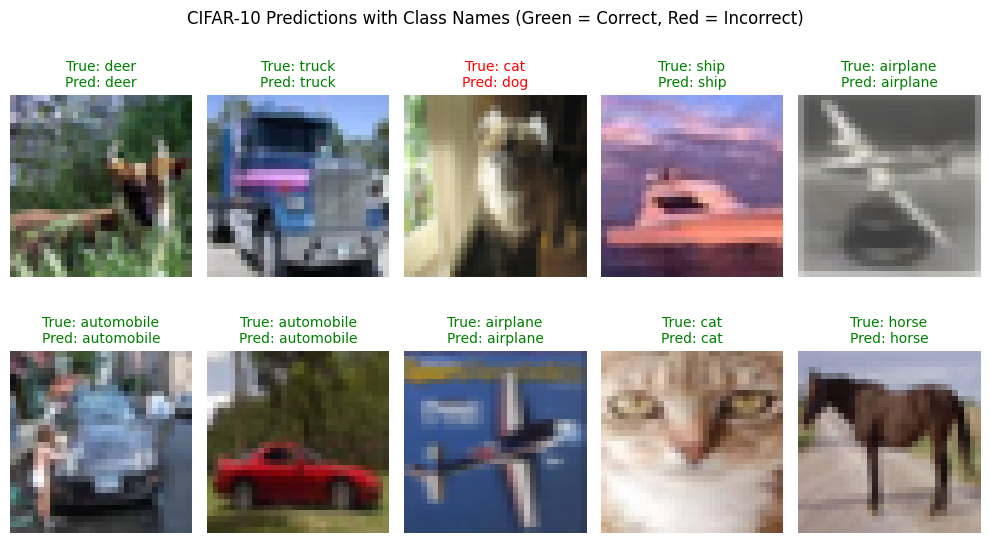

In [20]:
import matplotlib.pyplot as plt;

def plot_sample_predictions_with_names(model, x_test, y_test, class_names, num_samples=10):
    # CIFAR-10 class names
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Randomly select samples
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    
    # Get the selected images and labels
    sample_images = x_test[indices]
    sample_labels = y_test[indices]
    
    # Get predictions
    logits = model.forward_pass(sample_images, training=False)
    predictions = tf.argmax(logits, axis=1).numpy()
    
    plt.figure(figsize=(10, 6))
    
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        
        # Display image
        plt.imshow(sample_images[i])
        plt.axis('off')
        
        # Color based on correctness
        color = 'green' if predictions[i] == sample_labels[i] else 'red'
        
        # Get class names
        true_class = cifar10_classes[sample_labels[i]]
        pred_class = cifar10_classes[predictions[i]]
        
        plt.title(
            f"True: {true_class}\nPred: {pred_class}",
            color=color,
            fontsize=10
        )
    
    plt.suptitle("CIFAR-10 Predictions with Class Names (Green = Correct, Red = Incorrect)")
    plt.tight_layout()
    plt.show()

# Usage
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
plot_sample_predictions_with_names(model, x_test, y_test, cifar10_classes)